# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score


# Read the dataset

In [2]:
data = pd.read_csv("diabetes.csv")

In [3]:
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0      NaN  33.6   
1            1     85.0           66.0           29.0      NaN  26.6   
2            8    183.0           64.0            NaN      NaN  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [4]:
print("Total number of rows in dataset = {}".format(data.shape[0]))
print("Total number of columns in dataset = {}".format(data.shape[1]))

Total number of rows in dataset = 768
Total number of columns in dataset = 9


In [5]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### Calculating the sum of all the null values in each column

In [6]:
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                           8
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

### To fill these Nan values the data distribution needs to be understood

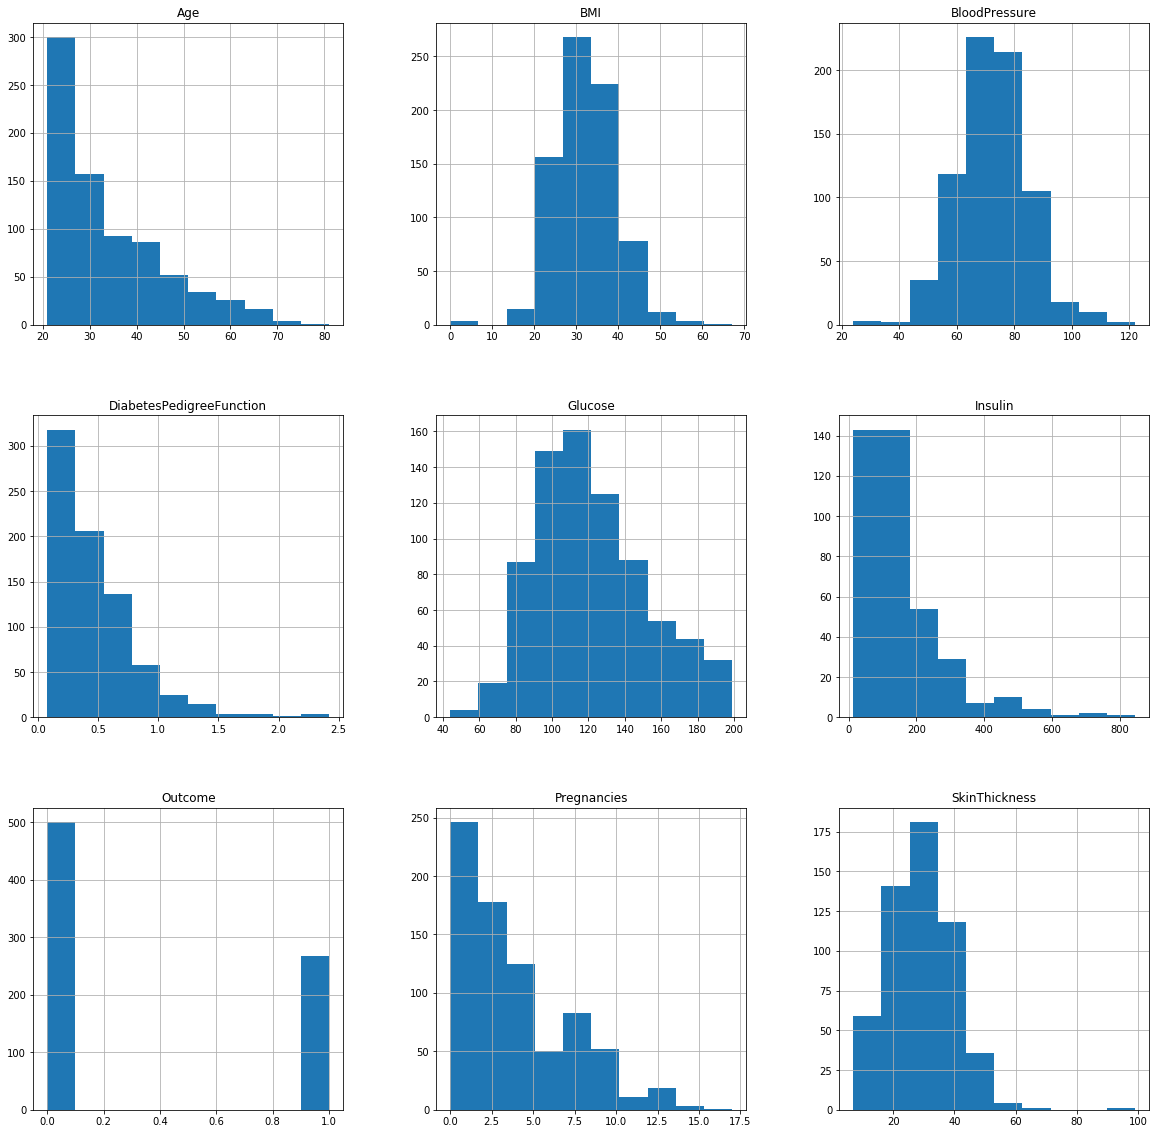

In [7]:
p = data.hist(figsize = (20,20))

### Aiming to impute nan values for the columns in accordance with their distribution

In [8]:
data['Glucose'].fillna(data['Glucose'].median(), inplace = True)
data['BloodPressure'].fillna(data['BloodPressure'].median(), inplace = True)
data['SkinThickness'].fillna(data['SkinThickness'].median(), inplace = True)
data['Insulin'].fillna(data['Insulin'].median(), inplace = True)
data['BMI'].fillna(data['BMI'].median(), inplace = True)
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Plot after NaN removal

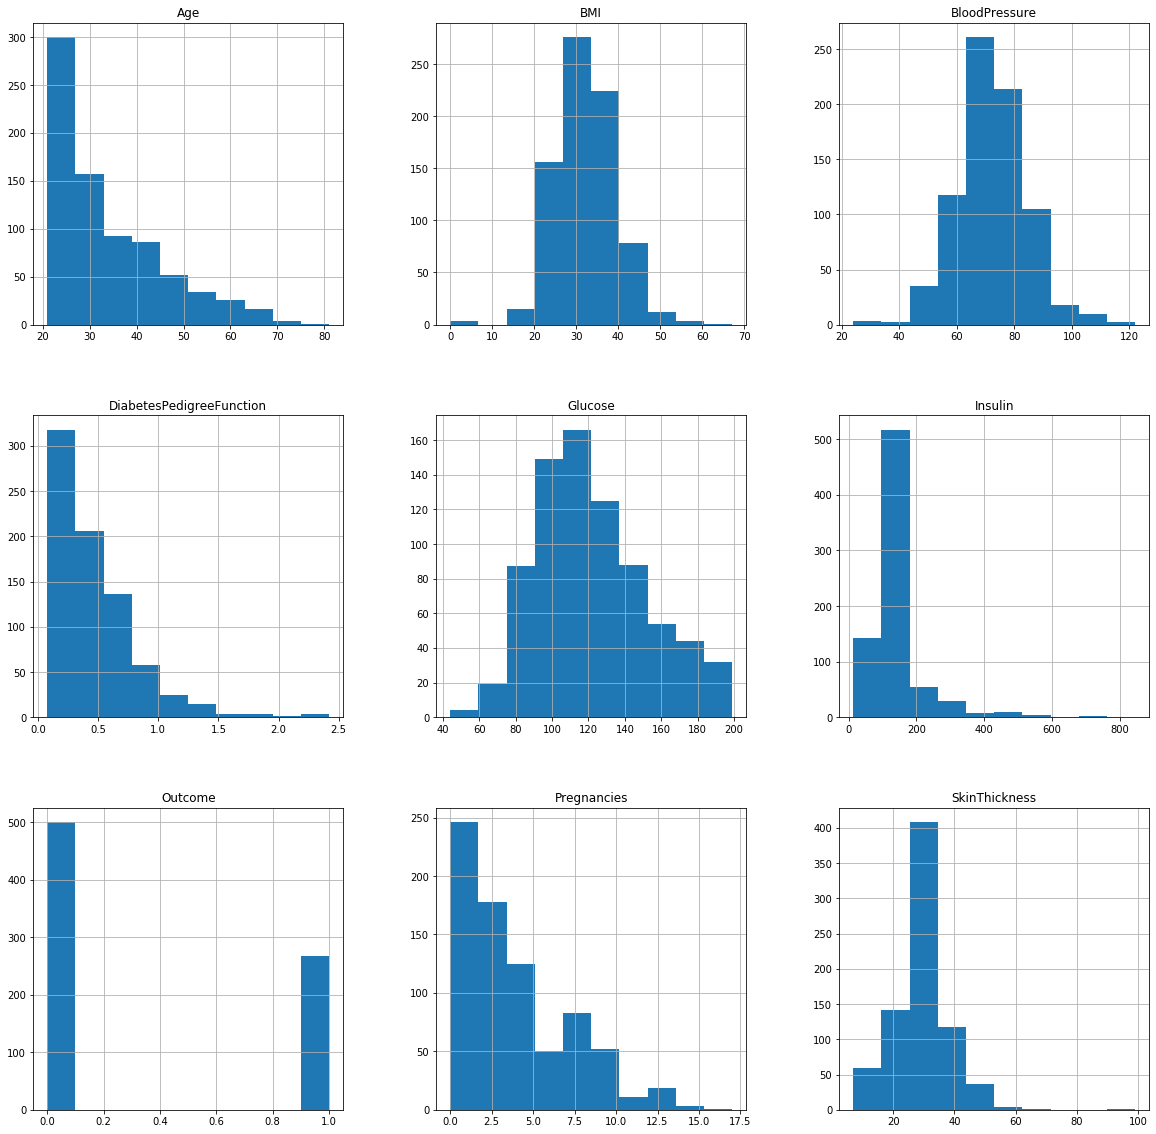

In [9]:
p = data.hist(figsize = (20,20))

## As we can compare there is a huge difference in the graph of Insulin and skin thickness after removal of NaN (not a number) 

In [10]:
fig = go.Figure(data=[go.Pie(labels=['Diabetic','Non-diabetic'],
                            values=data['Outcome'].value_counts(),
                            textinfo = 'label + percent')])
fig.show()

## 65.1% are diabetic in the dataset and 34.9% are non-diabetic 

In [11]:
def grouping_Preg(x):
    if x in range(0,5):
        return 1
    elif x in range(5,10):
        return 2
    elif x in range(10,15):
        return 3
    else:
        return 4

In [12]:
data['preg']=data['Pregnancies'].apply(grouping_Preg)

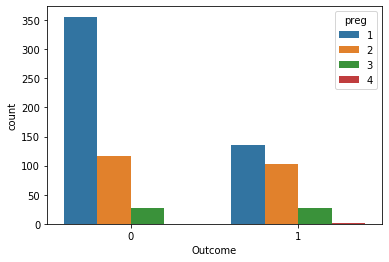

In [13]:
sns.countplot(x='Outcome', hue='preg', data=data)

In [14]:
data.groupby(['Pregnancies'])['Outcome'].sum()

Pregnancies
0     38
1     29
2     19
3     27
4     23
5     21
6     16
7     25
8     22
9     18
10    10
11     7
12     4
13     5
14     2
15     1
17     1
Name: Outcome, dtype: int64

### 0-5 pregnancies women are more prone to diabetes while 15+ are least in danger

In [15]:
def grouping_Age(x):
    if x in range(21,41):
        return 1
    elif x in range(41,61):
        return 2
    else:
        return 3

In [16]:
data['Age group']= data['Age'].apply(grouping_Age)

In [17]:
age_values = data['Age group'].value_counts()
fig = go.Figure(data=[go.Pie(labels=['Age: 21-41','Age: 41-61','Age: 61-81'],
                            values=age_values,
                            textinfo = 'label + percent')])
fig.show()

### 21-41 Age group are more susceptible to have diabetes

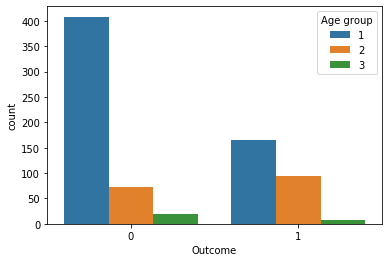

In [18]:
sns.countplot(x='Outcome', hue='Age group', data=data)

In [19]:
data['Age group'].value_counts()

1    574
2    167
3     27
Name: Age group, dtype: int64

In [20]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'preg',
       'Age group'],
      dtype='object')

In [21]:
data.Insulin.agg(['max','min','mean','median'])

max       846.000000
min        14.000000
mean      140.402344
median    125.000000
Name: Insulin, dtype: float64

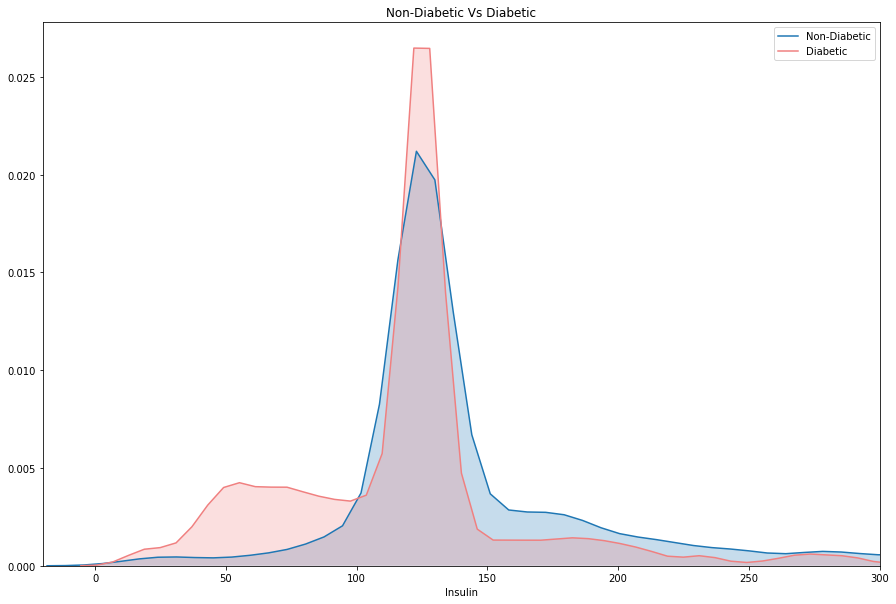

In [22]:
plt.figure(figsize=(15,10))

figure = sns.kdeplot(data['Insulin'][data.Outcome == 1],
                    shade=True)
sns.kdeplot(data['Insulin'][data.Outcome == 0],
                 color="lightcoral",   shade=True)
plt.legend(['Non-Diabetic', 'Diabetic'])
plt.title("Non-Diabetic Vs Diabetic")
plt.xlim(-20,300) 
figure.set(xlabel='Insulin')
plt.show()


### Less insulin means more chances for diabetes

In [23]:
data.BloodPressure.agg(['max','min','mean','median'])

max       122.000000
min        24.000000
mean       72.386719
median     72.000000
Name: BloodPressure, dtype: float64

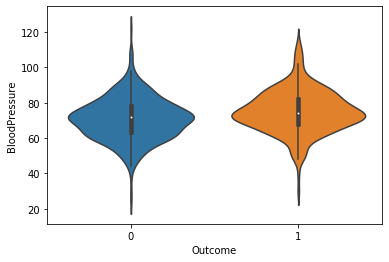

In [24]:
sns.violinplot(data=data,x='Outcome',y='BloodPressure')

If we observe minutely, we can see that the box plot for 1 (Diabetic) inside the violin is a little more away from the horizontal axis than the box plot for 0 (Non Diabetic). It can be implied that diabetics seem to have a higher blood pressure than the non-diabetics.

### So people with blood pressure in 1st and 5th category(i.e. 0-21, 81+) are more likely to have diabetes this means low or high bp

In [25]:
data.Glucose.agg(['max','min','mean','median'])

max       199.00000
min        44.00000
mean      121.65625
median    117.00000
Name: Glucose, dtype: float64

In [26]:
def grouping_Glucose(x):
    if x in range(0,50):
        return 1
    elif x in range(50,100):
        return 2
    elif x in range(100,150):
        return 3
    else:
        return 4

In [27]:
data['Glucose_categorized']= data['Glucose'].apply(grouping_Glucose)

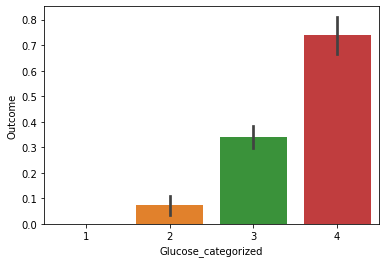

In [28]:
sns.barplot('Glucose_categorized', 'Outcome', data=data)
plt.show()

### According to the barplot people with high glucose level are more prone to diabetes

In [29]:
data.BMI.agg(['max','min','mean','median'])

max       67.100000
min        0.000000
mean      32.328516
median    32.250000
Name: BMI, dtype: float64

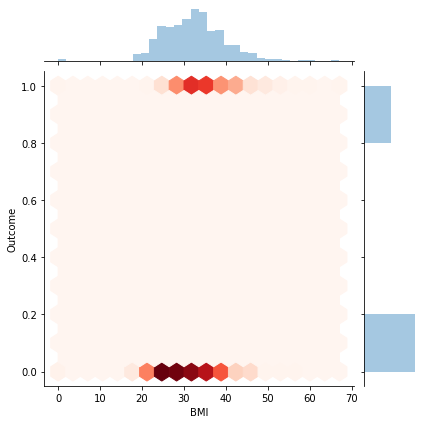

In [30]:
sns.jointplot(data=data, x='BMI', y='Outcome', kind='hex', cmap='Reds')

### According to this BMI group of 36-54 (i.e. obese and exterme obese) are more likely to have diabetes

In [31]:
data.DiabetesPedigreeFunction.agg(['max','min','mean','median'])

max       2.420000
min       0.078000
mean      0.471876
median    0.372500
Name: DiabetesPedigreeFunction, dtype: float64

In [32]:
data.groupby(['DiabetesPedigreeFunction'])['Outcome'].sum()

DiabetesPedigreeFunction
0.078    0
0.084    0
0.085    0
0.088    1
0.089    0
        ..
1.893    1
2.137    1
2.288    1
2.329    0
2.420    1
Name: Outcome, Length: 517, dtype: int64

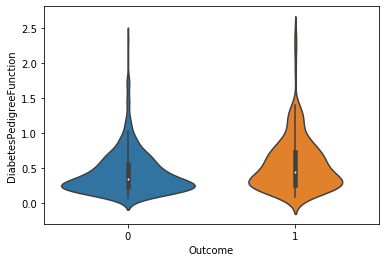

In [33]:
sns.violinplot(data=data,x='Outcome',y='DiabetesPedigreeFunction')

Diabetics seem to have a higher pedigree function that the non-diabetics. 

### Diabetes Pedigree Function provides data on diabetes mellitus history in relatives and genetic relationship of those relatives to the patient

In [34]:
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  preg  Age group  \
0                     0.627   50        1     2          2   
1                     0.351   31        0     1          1   
2                     0.672   32        1     2          1   
3                     0.167   21        0     1          1   
4                     2.288   33        1     1          1   

   Glucose_categorized  
0                    3  
1                    2  
2                    4  
3                    2  
4                    3

In [35]:
data= data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']]

# Heatmap correlation

### Correlation states how the features are related to each other or the target variable.Heatmap makes it easy to identify which features are most related to the target variable.

### Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

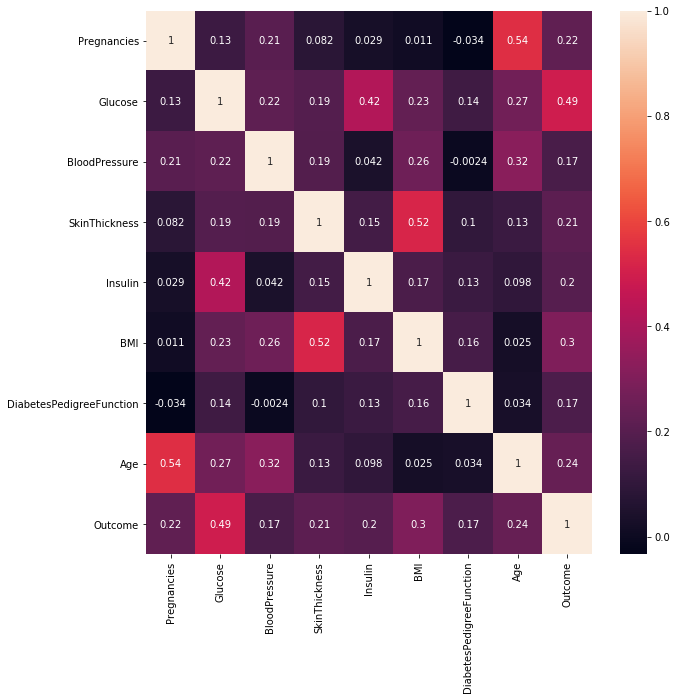

In [36]:
co=data.corr()
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(co,annot=True)

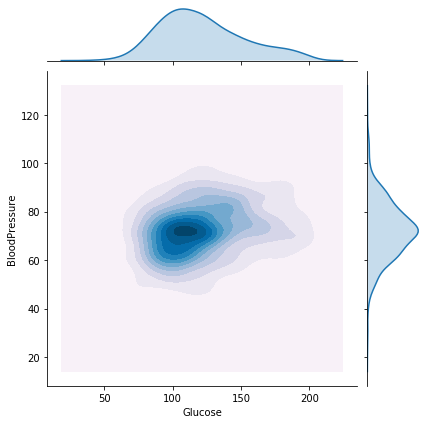

In [37]:
sns.jointplot(data=data,x='Glucose',y='BloodPressure',kind='kde',cmap='PuBu')

Joint plots in seaborn helps us to understand the trend seen among two features. As observed from the above plot we can see that most of the diabetic patients with glucose betweem 100-15 have blood pressure between 60-80 

## The heatmap shows that the outcome is least dependent upon Insulin and BMI 

In [38]:
X, y = data.drop('Outcome', axis=1), data['Outcome']
print(X.shape, y.shape)

(768, 8) (768,)


# Scaling the data
### Data Z is rescaled such that μ = 0 and 𝛔 = 1, and is done through this formula:  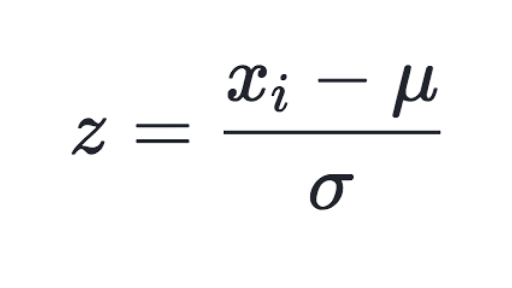

## Standardize features by removing the mean and scaling to unit variance

In [39]:
from sklearn.preprocessing import StandardScaler
norm=StandardScaler()
x=norm.fit_transform(data.drop('Outcome', axis=1))

In [40]:
x.ndim

2

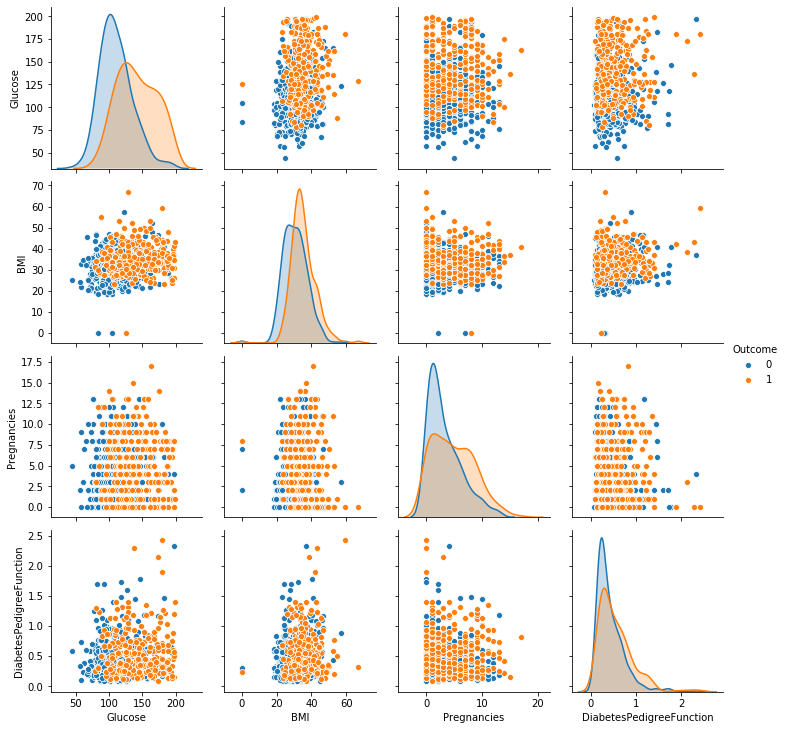

In [41]:
sns.pairplot(data[['Glucose','BMI','Pregnancies','DiabetesPedigreeFunction','Outcome']],hue='Outcome',height=2.5);

Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (768, 8)
LASSO best alpha:  0.007488103857590023
[('Glucose', 0.18968519594107391), ('BMI', 0.08226715076465037), ('Pregnancies', 0.0651383858038975), ('DiabetesPedigreeFunction', 0.03757871033043076), ('Age', 0.016180274837429228), ('SkinThickness', 0.004304710904700218), ('BloodPressure', -0.0), ('Insulin', -0.0)]


Text(0.5, 1.0, 'Top Features derived by LassoCV')

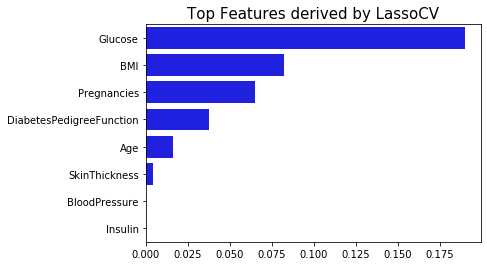

In [42]:
## to find significant features using LassoCV (all X_scaled)
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')
# Scale the Predictors on both the train and validation set
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# This is the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )

# display all coefficients in the model with optimal alpha
zipped = list(zip(X.columns, lasso_model.coef_)) 
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
print(zipped)
a,b = zip(*zipped)
sns.barplot(y=list(a), x=list(b), color='b')
plt.title('Top Features derived by LassoCV', size=15)

Text(0.5, 1.0, 'Top Features derived by Random Forest')

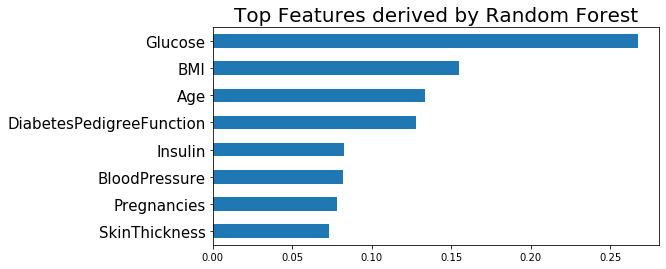

In [43]:
from sklearn.ensemble import RandomForestClassifier
X, y = data.drop('Outcome', axis=1), data['Outcome']
rfc = RandomForestClassifier( n_estimators=100)
rfc_model = rfc.fit(X, y)
(pd.Series(rfc_model.feature_importances_, index=X.columns)
    .nlargest(8)
    .plot(kind='barh', figsize=[8,4])
    .invert_yaxis())
plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

The figure above shows the relative importance of features and their contribution to the model. Since it was a small dataset with less columns, I didn’t use Feature Selection technique such as PCA.

# Based on the feature importance:
    1.)Glucose is the most important factor in determining the onset of diabetes followed by BMI and Age.
    2.)Other factors such as Diabetes Pedigree Function, Pregnancies, Blood Pressure, Skin Thickness and Insulin also                  contributes to the prediction.

In [44]:
# for linear data and model, p-value < 0.05 indicates a significant feature
import statsmodels.api as sm
X = sm.add_constant(X)  # need to add this to define the Intercept
# model / fit / summarize results
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     44.01
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           4.64e-58
Time:                        18:49:52   Log-Likelihood:                -374.32
No. Observations:                 768   AIC:                             766.6
Df Residuals:                     759   BIC:                             808.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9998      0.104     -9.629      0.000      -1.204      -0.796
Pregnancies                  0.0210      0.005      4.130      0.000       0.011       0.031
Glucose                      0.0066      0.001     11.979      0.000       0.006       0.008
BloodPressure               -0.0009      0.001     -0.672      0.502      -0.003       0.002
SkinThickness                0.0010      0.002      0.508      0.612      -0.003       0.005
Insulin                     -0.0002      0.000     -0.918      0.359      -0.001       0.000
BMI                          0.0124      0.002      5.084      0.000       0.008       0.017
DiabetesPedigreeFunction     0.1326      0.044      2.998      0.003       0.046       0.219
Age                          0.0019      0.002      1.205      0.229      -0.001       0.005
==============================================================================
Omnibus:                       35.268   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.180
Skew:                           0.335   Prob(JB):                     3.41e-06
Kurtosis:                       2.419   Cond. No.                     1.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### We now split our processed dataset into Training and Test data. The Test data size is take to be 20% of the entire data

In [45]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(data.drop('Outcome', axis=1), y, test_size=0.2,random_state=45)
print('xtrain', xtrain.shape)
print('ytrain', ytrain.shape)
print('xtest', xtest.shape)
print('ytest', ytest.shape)

xtrain (614, 8)
ytrain (614,)
xtest (154, 8)
ytest (154,)


# Cross Validation
## Use StratifiedKFold, especially if target class is imbalance

In [46]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
## Baseline model performance evaluation
# kf = KFold(n_splits=5, shuffle=True, random_state=SEED)   # this may result in imbalance classes in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# to give model baseline report in dataframe 
def baseline_report(model, xtrain, xtest, ytrain, ytest, name):
    model.fit(xtrain, ytrain)
    accuracy= np.mean(cross_val_score(model, xtrain, ytrain, cv=kf, scoring='accuracy'))
    precision= np.mean(cross_val_score(model, xtrain, ytrain, cv=kf, scoring='precision'))
    recall= np.mean(cross_val_score(model, xtrain, ytrain, cv=kf, scoring='recall'))
    f1score= np.mean(cross_val_score(model, xtrain, ytrain, cv=kf, scoring='f1'))
    rocauc= np.mean(cross_val_score(model, xtrain, ytrain, cv=kf, scoring='roc_auc'))
    y_pred= model.predict(xtest)
    logloss= log_loss(ytest, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [0]       })   # timetaken: to be used for comparison later
    return df_model

# to evaluate baseline models
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
svc = SVC()
linearsvc = LinearSVC()
# to concat all models
df_models = pd.concat([baseline_report(logit, xtrain, xtest, ytrain, ytest, 'LogisticRegression'),
                       baseline_report(knn, xtrain, xtest, ytrain, ytest, 'KNN'),
                       baseline_report(decisiontree, xtrain, xtest, ytrain, ytest, 'DecisionTree'),
                       baseline_report(randomforest, xtrain, xtest, ytrain, ytest, 'RandomForest'),
                       baseline_report(svc, xtrain, xtest, ytrain, ytest, 'SVC'),
                       baseline_report(linearsvc, xtrain, xtest, ytrain, ytest, 'LinearSVC')
                       ], axis=0).reset_index()
df_models = df_models.drop('index', axis=1)
df_models

model  accuracy  precision    recall   f1score    rocauc  \
0  LogisticRegression  0.768799   0.708077  0.596512  0.646770  0.819839   
1                 KNN  0.732894   0.640891  0.564376  0.600190  0.761263   
2        DecisionTree  0.740997   0.602526  0.628647  0.633694  0.714598   
3        RandomForest  0.770425   0.711905  0.601797  0.647681  0.829591   
4                 SVC  0.755684   0.736561  0.490803  0.587684  0.814538   
5           LinearSVC  0.553912   0.519850  0.176216  0.061921  0.706605   

     logloss  timetaken  
0   8.522628          0  
1   9.644063          0  
2  11.886888          0  
3   8.971204          0  
4   8.522628          0  
5  11.213888          0

# Model Performance Analysis
## 1. Confusion Matrix
###    The confusion matrix is a technique used for summarizing the performance of a classification algorithm i.e. it has binary outputs. 

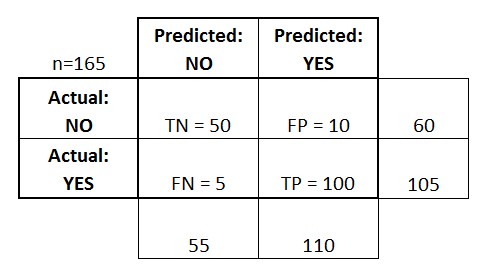

## 2. F1-score
###     F1 score is a measure of a test's accuracy. It is calculated from the precision and recall of the test, it conveys the balance between the precision and the recall. 
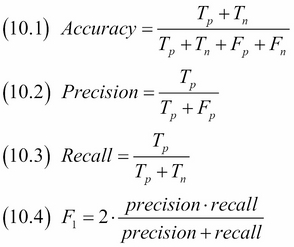

# Hyperparameter tuning

In [47]:
def model_report(model, X_train, X_test, y_train, y_test, model_name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    accuracy      = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)
    plt.xlabel('Predicted values')
    plt.ylabel('Truth values')
    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    df_model = pd.DataFrame({'model'        : [model_name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [1000]       })   # timetaken for comparison later
    return df_model

# GaussianNB


Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4902,  0.100->0.6269,  0.200->0.6154,  0.300->0.6055,  0.400->0.6214,  0.500->0.6122,  0.600->0.5806,  0.700->0.5747,  0.800->0.5610,  0.900->0.4384,  1.000->0.0000,  
Looping decimal place 2
0.000->0.4902,  0.010->0.5213,  0.020->0.5444,  0.030->0.5614,  0.040->0.5697,  0.050->0.5714,  0.060->0.5906,  0.070->0.6069,  0.080->0.6154,  0.090->0.6286,  0.100->0.6269,  0.110->0.6364,  0.120->0.6260,  0.130->0.6250,  0.140->0.6299,  0.150->0.6349,  0.160->0.6066,  0.170->0.6102,  0.180->0.6102,  0.190->0.6102,  0.200->0.6154,  
Looping decimal place 3
0.100->0.6269,  0.101->0.6269,  0.102->0.6269,  0.103->0.6269,  0.104->0.6316,  0.105->0.6316,  0.106->0.6316,  0.107->0.6364,  0.108->0.6364,  0.109->0.6364,  0.110->0.6364,  0.111->0.6364,  0.112->0.6364,  0.113->0.6364,  0.114->0.6364,  0.115->0.6364,  0.116->0.6260,  0.117->0.6260,  0.118->0.6260,  0.119->0.6260,  0.1

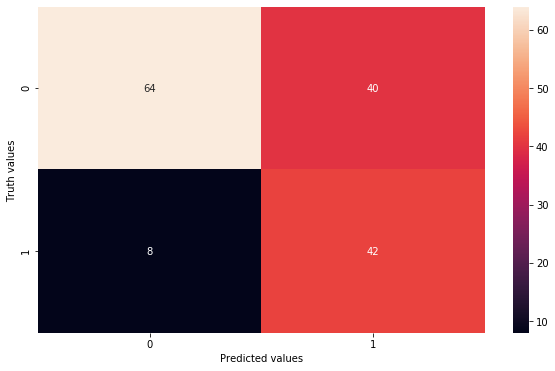

In [48]:
time1 = time.time()
gnb = GaussianNB()
model1 = model_report(gnb, xtrain, xtest, ytrain, ytest, 'GaussianNB')
model1.timetaken[0] = time.time() - time1

# BernoulliNB


Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4902,  0.100->0.4902,  0.200->0.4902,  0.300->0.4902,  0.400->0.0000,  0.500->0.0000,  0.600->0.0000,  0.700->0.0000,  0.800->0.0000,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.000->0.4902,  0.010->0.4902,  0.020->0.4902,  0.030->0.4902,  0.040->0.4902,  0.050->0.4902,  0.060->0.4902,  0.070->0.4902,  0.080->0.4902,  0.090->0.4902,  0.100->0.4902,  
Looping decimal place 3
0.000->0.4902,  0.001->0.4902,  0.002->0.4902,  0.003->0.4902,  0.004->0.4902,  0.005->0.4902,  0.006->0.4902,  0.007->0.4902,  0.008->0.4902,  0.009->0.4902,  0.010->0.4902,  optimal F1 score = 0.4902
optimal threshold = 0.000
BernoulliNB accuracy score is
Training: 64.50%
Test set: 67.53%

Adjust threshold to 0.25:
Precision: 0.3247,   Recall: 1.0000,   F1 Score: 0.4902
BernoulliNB confusion matrix: 
 [[  0 104]
 [  0  50]]

Default threshold of 0.50:
Precision: 0.0000,   Reca

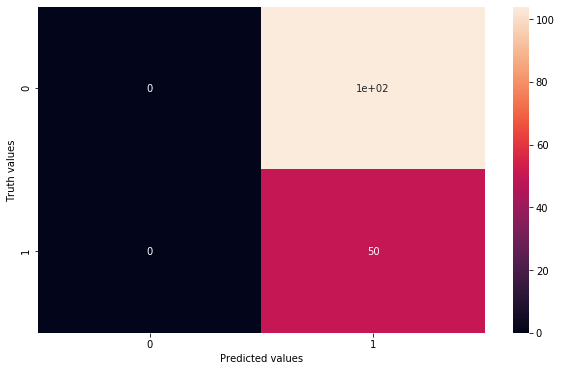

In [49]:

time1 = time.time()
bnb = BernoulliNB()
model2 = model_report(bnb, xtrain, xtest, ytrain, ytest, 'BernoulliNB')
model2.timetaken[0] = time.time() - time1

# MultinomialNB


Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4950,  0.100->0.5468,  0.200->0.6102,  0.300->0.6250,  0.400->0.5872,  0.500->0.5400,  0.600->0.4783,  0.700->0.4598,  0.800->0.4000,  0.900->0.2740,  1.000->0.1071,  
Looping decimal place 2
0.200->0.6102,  0.210->0.6102,  0.220->0.6102,  0.230->0.6154,  0.240->0.6154,  0.250->0.6034,  0.260->0.6034,  0.270->0.6087,  0.280->0.6195,  0.290->0.6250,  0.300->0.6250,  0.310->0.6126,  0.320->0.6126,  0.330->0.6126,  0.340->0.6000,  0.350->0.6000,  0.360->0.6000,  0.370->0.6000,  0.380->0.6000,  0.390->0.5872,  0.400->0.5872,  
Looping decimal place 3
0.280->0.6195,  0.281->0.6195,  0.282->0.6195,  0.283->0.6195,  0.284->0.6195,  0.285->0.6195,  0.286->0.6195,  0.287->0.6195,  0.288->0.6250,  0.289->0.6250,  0.290->0.6250,  0.291->0.6250,  0.292->0.6250,  0.293->0.6250,  0.294->0.6250,  0.295->0.6250,  0.296->0.6250,  0.297->0.6250,  0.298->0.6250,  0.299->0.6250,  0.3

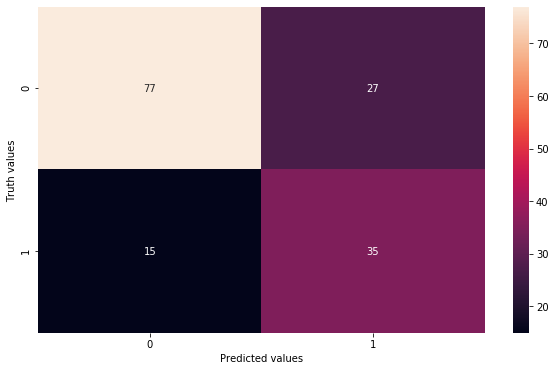

In [50]:

time1 = time.time()
mnb = MultinomialNB()
model3 = model_report(mnb, xtrain, xtest, ytrain, ytest, 'MultinomialNB')
model3.timetaken[0] = time.time() - time1

# LogisticRegression


Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.6203, 0.6162, 0.6231, 0.6047, 0.6253, 0.6158, 0.5957, 0.6309, 0.6139, 0.6293, 0.6353, 0.6217, 0.6318, 0.6406, 0.6237, 0.6165, 0.6134, 0.6391, 0.6403, 0.6317, 0.6283, 0.6112, 0.6005, 0.6123, 0.6076, 0.6157, 0.5634, 0.5918, 0.5850, 0.5738, 0.6015, 0.6011, 0.5693, 0.6178, 0.6287, 0.6127, 0.5613, 0.5960, 0.5979, 0.6072, 0.5933, 0.5982, 0.5818, 0.5436, 0.5831, 0.6138, 0.6003, 0.5582, 0.5519, 0.5426, 0.5789, 0.5899, 0.5793, 0.5995, 0.5594, 0.5451, 0.5829, 0.6097, 0.5834, 0.5999, 0.5861, 0.5969, 0.5859, 0.5675, 0.5503, 0.5839, 0.6151, 0.6077, 0.6000, 0.5763, 0.5864, 0.6292, 0.5768, 0.6242, 0.6404, 0.6192, 0.5779, 0.5901, 0.5984, 0.5812, 0.5828, 0.5711, 0.6300, 0.5836, 0.5781, 0.5777, 0.5766, 0.5689, 0.5882, 0.5701, 0.5859, 0.5677, 0.5987, 0.5889, 0.6169, 0.6204, 0.6064, 0.5876, 0.5820, 0.5897, 0.5863, 0.5733, 0.5917, 0.6050, 0.5784, 0.5896, 0.6062, 0.6167, 0.

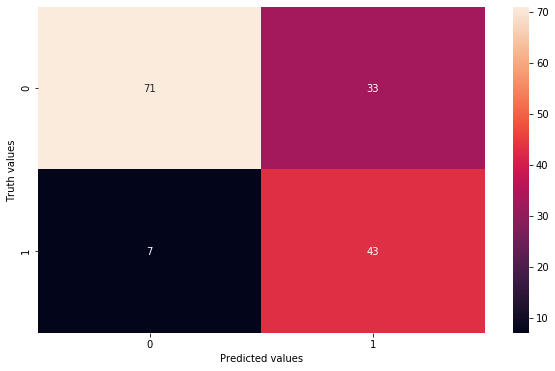

In [51]:
time1 = time.time()
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=42, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, xtrain, ytrain, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logit = LogisticRegression(C = optimal_c)
model4 = model_report(logit, xtrain, xtest, ytrain, ytest, 'LogisticRegression')
model4.timetaken[0] = time.time() - time1

# KNN


Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.5600, 0.5214, 0.6072, 0.5509, 0.6268, 0.5887, 0.6419, 0.5616, 0.6200, 0.5874, 0.6032, 0.5860, 0.5978, 0.5645, 0.5986, 0.5610, 0.5961, 0.5532, 0.5929, 0.5647, optimal cv F1 score = 0.6419
optimal value of K = 7

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5714,  0.100->0.5714,  0.200->0.5970,  0.300->0.5766,  0.400->0.5766,  0.500->0.5686,  0.600->0.5227,  0.700->0.5227,  0.800->0.4800,  0.900->0.1071,  1.000->0.1071,  
Looping decimal place 2
0.100->0.5714,  0.110->0.5714,  0.120->0.5714,  0.130->0.5714,  0.140->0.5714,  0.150->0.5970,  0.160->0.5970,  0.170->0.5970,  0.180->0.5970,  0.190->0.5970,  0.200->0.5970,  0.210->0.5970,  0.220->0.5970,  0.230->0.5970,  0.240->0.5970,  0.250->0.5970,  0.260->0.5970,  0.270->0.5970,  0.280->0.5970,  0.290->0.5766,  0.300->0.5766,  
Looping decimal place 3

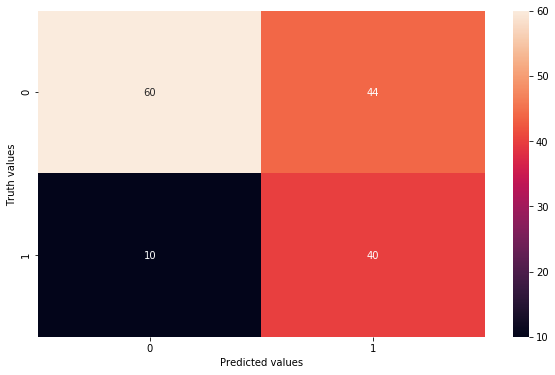

In [52]:
time1 = time.time()
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=42, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, xtrain, ytrain, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

knn = KNeighborsClassifier(n_neighbors = optimal_k)
model5 = model_report(knn, xtrain, xtest, ytrain, ytest, 'KNN')
model5.timetaken[0] = time.time() - time1

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(xtrain, ytrain)
y_pred = knn.predict(xtest)
print(metrics.classification_report(ytest, y_pred))

# DecisionTreeClassifier


Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.5660, 0.5283, 0.5727, 0.6166, 0.6133, 0.6360, 0.6363, 0.5882, 0.5718, optimal F1 score = 0.6363
optimal max_depth = 8

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4932,  0.100->0.5410,  0.200->0.5088,  0.300->0.5179,  0.400->0.5234,  0.500->0.5283,  0.600->0.5283,  0.700->0.5192,  0.800->0.4894,  0.900->0.3902,  1.000->0.3902,  
Looping decimal place 2
0.000->0.4932,  0.010->0.4932,  0.020->0.4932,  0.030->0.5410,  0.040->0.5410,  0.050->0.5410,  0.060->0.5410,  0.070->0.5410,  0.080->0.5410,  0.090->0.5410,  0.100->0.5410,  0.110->0.5410,  0.120->0.5410,  0.130->0.5410,  0.140->0.5410,  0.150->0.5424,  0.160->0.5424,  0.170->0.5217,  0.180->0.5217,  0.190->0.5217,  0.200->0.5088,  
Looping decimal place 3
0.140->0.5410,  0.141->0.5410,  0.142->0.5410,  0.143->0.5424,  0.144->0.5424,  0.145->0.5424,  

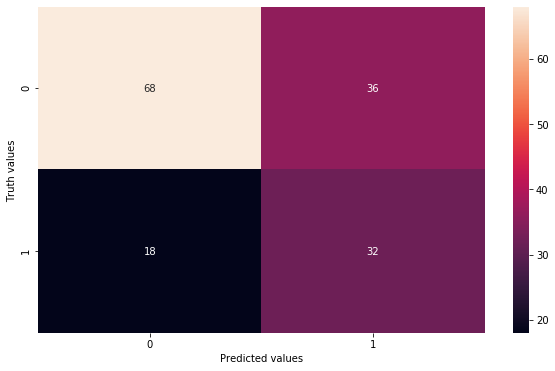

In [53]:

time1 = time.time()
print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=42, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, xtrain, ytrain, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model6 = model_report(decisiontree, xtrain, xtest, ytrain, ytest, 'DecisionTree')
model6.timetaken[0] = time.time() - time1
# Note: results keep changing in each run

# RandomForestClassifier       (quite slow)


Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.6571, 150->0.6544, 200->0.6602, 250->0.6477, 300->0.6633, 350->0.6587, 400->0.6492, 450->0.6583, 500->0.6525, optimal F1 score = 0.6633
optimal n_estimators = 300

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4926,  0.100->0.5818,  0.200->0.6389,  0.300->0.6613,  0.400->0.6486,  0.500->0.6139,  0.600->0.5455,  0.700->0.4384,  0.800->0.2812,  0.900->0.0769,  1.000->0.0000,  
Looping decimal place 2
0.200->0.6389,  0.210->0.6241,  0.220->0.6286,  0.230->0.6277,  0.240->0.6277,  0.250->0.6222,  0.260->0.6316,  0.270->0.6412,  0.280->0.6357,  0.290->0.6560,  0.300->0.6613,  0.310->0.6613,  0.320->0.6446,  0.330->0.6446,  0.340->0.6555,  0.350->0.6441,  0.360->0.6379,  0.370->0.6435,  0.380->0.6491,  0.390->0.6549,  0.400->0.6486,  
Looping decimal place 3
0.290->0.6560,  0.291->0.6560,  0.292->0

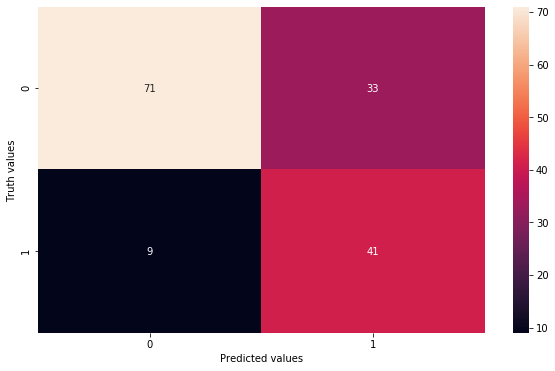

In [54]:

time1 = time.time()
print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=42, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, xtrain, ytrain, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

randomforest = RandomForestClassifier(n_estimators=optimal_n)
model7 = model_report(randomforest, xtrain, xtest, ytrain, ytest, 'RandomForest')
model7.timetaken[0] = time.time() - time1
# Note: results keep changing in each run

# SVC


Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4902,  0.100->0.5319,  0.200->0.6569,  0.300->0.6000,  0.400->0.5743,  0.500->0.5745,  0.600->0.5412,  0.700->0.5000,  0.800->0.3582,  0.900->0.2333,  1.000->0.0000,  
Looping decimal place 2
0.100->0.5319,  0.110->0.5435,  0.120->0.5714,  0.130->0.5765,  0.140->0.5939,  0.150->0.6049,  0.160->0.6234,  0.170->0.6395,  0.180->0.6573,  0.190->0.6714,  0.200->0.6569,  0.210->0.6269,  0.220->0.6154,  0.230->0.6142,  0.240->0.6116,  0.250->0.6000,  0.260->0.6050,  0.270->0.5983,  0.280->0.6034,  0.290->0.5965,  0.300->0.6000,  
Looping decimal place 3
0.180->0.6573,  0.181->0.6573,  0.182->0.6573,  0.183->0.6667,  0.184->0.6667,  0.185->0.6667,  0.186->0.6667,  0.187->0.6714,  0.188->0.6714,  0.189->0.6714,  0.190->0.6714,  0.191->0.6714,  0.192->0.6714,  0.193->0.6714,  0.194->0.6667,  0.195->0.6667,  0.196->0.6667,  0.197->0.6667,  0.198->0.6569,  0.199->0.6569,  0.2

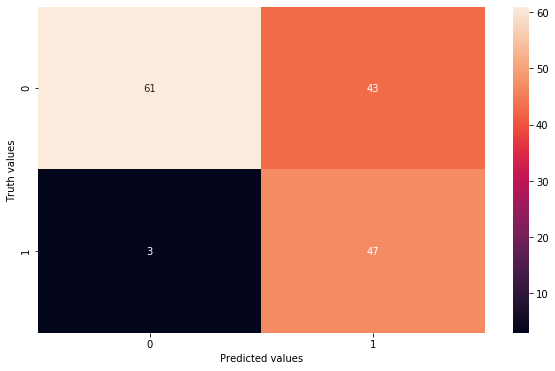

In [55]:

time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model8 = model_report(svc, xtrain, xtest, ytrain, ytest, 'SVC')
model8.timetaken[0] = time.time() - time1

# LinearSVC

In [56]:

time1 = time.time()
linearsvc = LinearSVC()
# model9 = model_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')   # model has no attribute 'predict_proba'

linearsvc.fit(xtrain, ytrain)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(xtrain, ytrain)))  # score uses accuracy
accuracy      = linearsvc.score(xtest, ytest)
print('Test set: {:.2f}%'.format(100*accuracy))

y_pred = linearsvc.predict(xtest)
print(classification_report(ytest, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(ytest, y_pred))

precision    = precision_score(ytest, y_pred)
recall       = recall_score(ytest, y_pred)
f1score      = f1_score(ytest, y_pred) 
rocauc       = roc_auc_score(ytest, y_pred)
logloss      = log_loss(ytest, y_pred)
print('LinearSVC AUC: {:.4f}'.format(rocauc))
print('LinearSVC Log-loss: {:.4f}'.format(logloss))

model9 = pd.DataFrame({'model'        : ['LinearSVC'],
                       'accuracy'     : [accuracy],
                       'precision'    : [precision],
                       'recall'       : [recall],
                       'f1score'      : [f1score],
                       'rocauc'       : [rocauc],
                       'logloss'      : [logloss],
                       'timetaken'    : [time.time() - time1]       })
# Note: results keep changing in each run

LinearSVC accuracy score is
Training: 65.80%
Test set: 68.18%
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       104
           1       1.00      0.02      0.04        50

    accuracy                           0.68       154
   macro avg       0.84      0.51      0.42       154
weighted avg       0.78      0.68      0.56       154

LinearSVC confusion matrix: 
 [[104   0]
 [ 49   1]]
LinearSVC AUC: 0.5100
LinearSVC Log-loss: 10.9896


# Compiling the results of all tuned models

In [57]:
# concat all models
df_models_tuned = pd.concat([model1,model2,model3,model4,model5,model6,model7,model8,model9],axis = 0).reset_index()
df_models_tuned.drop('index', axis=1, inplace=True)
df_models_tuned

model  accuracy  precision  recall   f1score    rocauc  \
0          GaussianNB  0.753247   0.512195    0.84  0.636364  0.787692   
1         BernoulliNB  0.675325   0.324675    1.00  0.490196  0.463750   
2       MultinomialNB  0.701299   0.564516    0.70  0.625000  0.721538   
3  LogisticRegression  0.772727   0.565789    0.86  0.682540  0.812308   
4                 KNN  0.714286   0.476190    0.80  0.597015  0.759904   
5        DecisionTree  0.675325   0.470588    0.64  0.542373  0.643558   
6        RandomForest  0.740260   0.554054    0.82  0.661290  0.800865   
7                 SVC  0.753247   0.522222    0.94  0.671429  0.805577   
8           LinearSVC  0.681818   1.000000    0.02  0.039216  0.510000   

     logloss  timetaken  
0   0.683910   0.000000  
1   0.633449   0.000000  
2   1.075402   0.000000  
3   0.501296  62.000000  
4   1.592056   3.000000  
5   7.012873   1.000000  
6   0.510430  67.000000  
7   0.526856   0.000000  
8  10.989611   0.108084

In [58]:
df_models # compare with baseline results before tuning

model  accuracy  precision    recall   f1score    rocauc  \
0  LogisticRegression  0.768799   0.708077  0.596512  0.646770  0.819839   
1                 KNN  0.732894   0.640891  0.564376  0.600190  0.761263   
2        DecisionTree  0.740997   0.602526  0.628647  0.633694  0.714598   
3        RandomForest  0.770425   0.711905  0.601797  0.647681  0.829591   
4                 SVC  0.755684   0.736561  0.490803  0.587684  0.814538   
5           LinearSVC  0.553912   0.519850  0.176216  0.061921  0.706605   

     logloss  timetaken  
0   8.522628          0  
1   9.644063          0  
2  11.886888          0  
3   8.971204          0  
4   8.522628          0  
5  11.213888          0

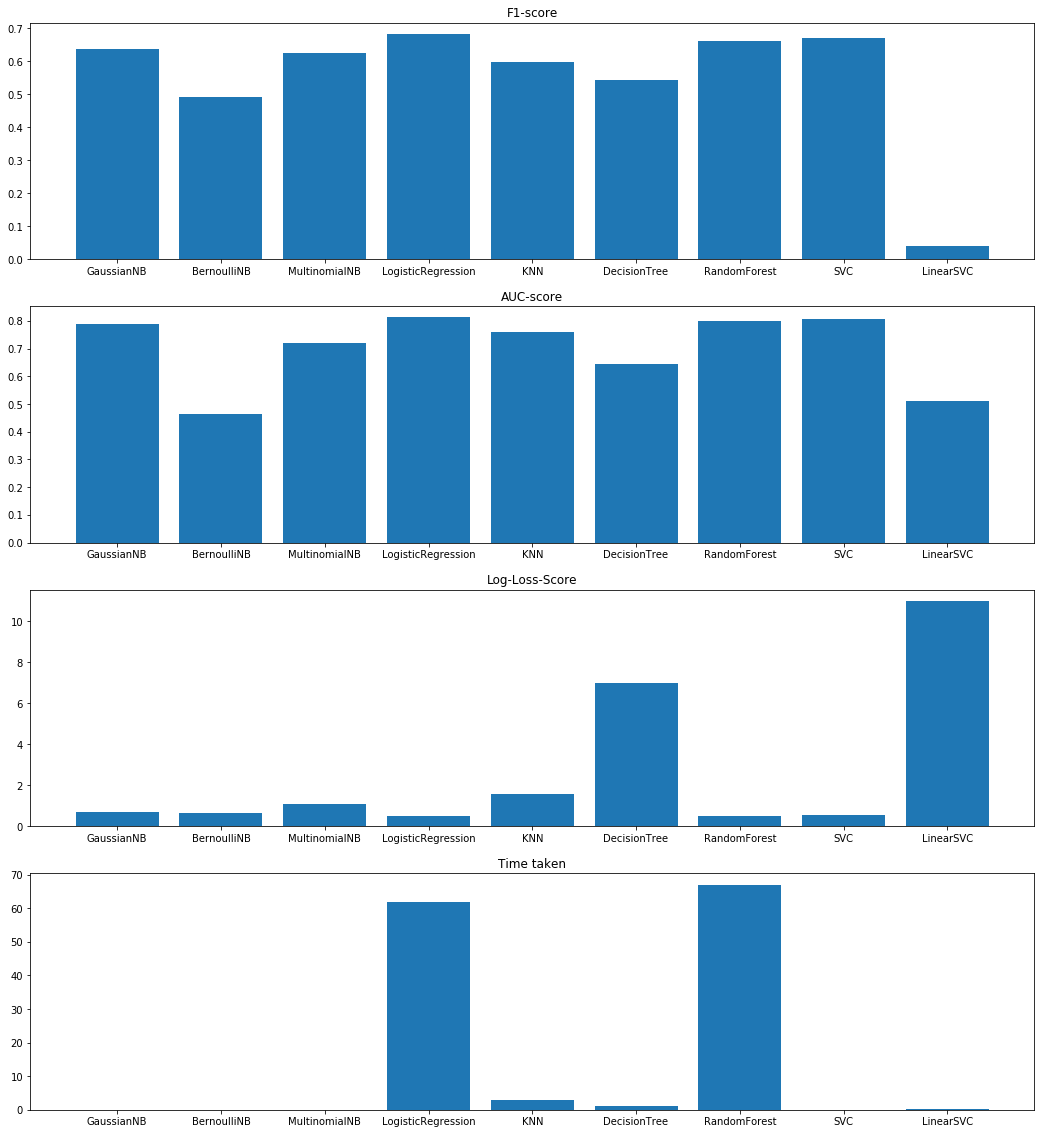

In [59]:
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(df_models_tuned.model, df_models_tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(df_models_tuned.model, df_models_tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(df_models_tuned.model, df_models_tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(df_models_tuned.model, df_models_tuned.timetaken)
ax[3].set_title('Time taken')

# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

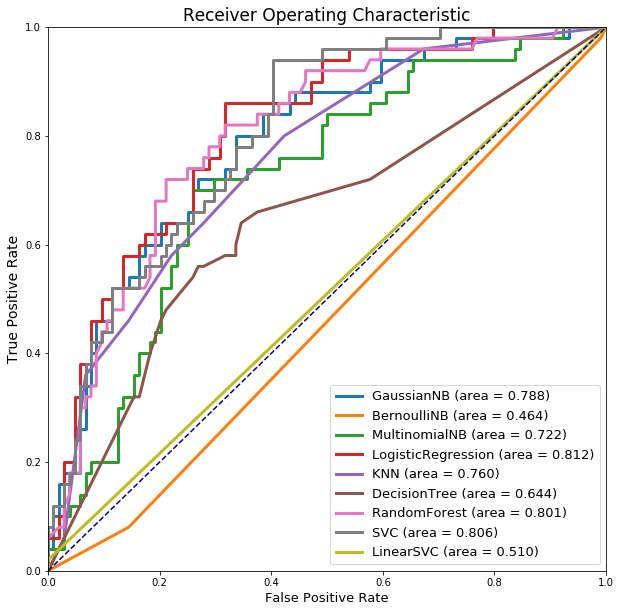

In [60]:
plt.figure(figsize=(10,10))

model_name = [gnb, bnb, mnb, logit, knn, decisiontree, randomforest, svc, linearsvc]

for i in range(8):
    y_pred = model_name[i].predict_proba(xtest)[:,1]
    fpr, tpr, thresholds = roc_curve(ytest, y_pred)
    plt.plot(fpr, tpr, lw=3, label=df_models_tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

y_pred = linearsvc.predict(xtest)   # linearsvc has no attribute 'predict_proba'
fpr, tpr, thresholds = roc_curve(ytest, y_pred)
plt.plot(fpr, tpr, lw=3, label='LinearSVC (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [61]:
# see how model confusion matrix varies with threshold
bestmodel = gnb

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (bestmodel.predict(X_test) is done automatically with a threshold of 0.5)
    y_pred = (bestmodel.predict_proba(xtest)[:, 1] >= threshold)
    conf = confusion_matrix(ytest, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no diabetes', 'diabetes'],
           yticklabels=['no diabetes', 'diabetes']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
# bestmodel = LogisticRegression(C = optimal_c)
# bestmodel.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(bestmodel, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

# Winning model: 

In [62]:
#RandomForest AUC: 0.7920
#Optimal threshold 0.350
#Precision: 0.5735,   Recall: 0.7800,   F1 Score: 0.6610
#RandomForest confusion matrix: 
# [[75 29]
# [11 39]]

In [63]:
#GaussianNB AUC: 0.7877
#Optimal threshold 0.107
#Precision: 0.5122,   Recall: 0.8400,   F1 Score: 0.6364
#GaussianNB confusion matrix: 
# [[64 40]
# [ 8 42]]

In [64]:
# Difference between roc_auc_score(y_test, y_pred) and auc(fpr, tpr)
y_pred = gnb.predict(xtest)
model_roc_auc = roc_auc_score(ytest, y_pred)   # this is AUC score when threshold is default 0.5
print('gnb', 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 

y_pred = gnb.predict_proba(xtest)[:,1]>0.5    # predict_proba to adjust threshold to 0.5, same results
fpr, tpr, thresholds = roc_curve(ytest, y_pred)
model_auc = auc(fpr, tpr)
print('gnb', 'AUC: {:.4f}'.format(model_auc))

y_pred = gnb.predict_proba(xtest)[:,1]   # use this for optimal threshold after tuning
fpr, tpr, thresholds = roc_curve(ytest, y_pred)
model_auc = auc(fpr, tpr)
print('gnb', 'AUC: {:.4f}'.format(model_auc))

gnb roc_auc_score: 0.7135
gnb AUC: 0.7135
gnb AUC: 0.7877


# Appendix: Use GridSearchCV to tune the model, eg. Logistic Regression
For most algorithms, there are parameters to tune to model the data better. One approach is to use grid search to find a suitable parameter that builds an optimal model.

In [65]:
# pass in parameters of all these values in the grids, see which gives the best score.
param_grid = {'C': [0.01, 0.1, 1, 10, 20]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), 
                    param_grid, cv=5, scoring='f1') # cv=5 refers to cross validation in the training dataset

grid.fit(xtrain, ytrain)

print("Best cross-validation score: {:.3f}".format(grid.best_score_))   # scoring='f1'; or default using accuracy
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

#make prediction
lr = grid.best_estimator_
lr.fit(xtrain, ytrain)
y_pred = lr.predict(xtest)
print('Testing metrics after grid search')
print('Accuracy', accuracy_score(ytest, y_pred))
print('Precision', precision_score(ytest, y_pred))
print('Recall', recall_score(ytest, y_pred))

Best cross-validation score: 0.620
Best parameters:  {'C': 20}
Best estimator:  LogisticRegression(C=20, solver='liblinear')
Testing metrics after grid search
Accuracy 0.7467532467532467
Precision 0.627906976744186
Recall 0.54


# Appendix: To handle imbalance data
This two-class dataset seems imbalanced (65% vs 35%). As a result, there is a possibility that one class is over-represented and the model built might be biased towards to majority. I have tried to solve this by oversampling the smaller class but there was no improvement. F1-score dropped from 0.66 to 0.63

In [66]:
# baseline model performance (before  oversampling)
print('X_train.shape:', xtrain.shape)
print(pd.value_counts(pd.Series(ytrain)))
gnb.fit(xtrain, ytrain)
y_pred = gnb.predict(xtest)
print('Model accuracy is', accuracy_score(ytest, y_pred))
print('Model accuracy is', gnb.score(xtest, ytest))   # same result (.score uses accuracy)
print(classification_report(ytest, y_pred))
print(confusion_matrix(ytest, y_pred))

X_train.shape: (614, 8)
0    396
1    218
Name: Outcome, dtype: int64
Model accuracy is 0.7532467532467533
Model accuracy is 0.7532467532467533
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       104
           1       0.62      0.60      0.61        50

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154

[[86 18]
 [20 30]]


In [67]:
# Handling imbalance data - Rerunning above with resampled data - using oversampling
# create fake sample data into the imbalanced side to balance it out.
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(xtrain, ytrain.ravel())

print('X_train_sm.shape:', X_train_sm.shape)
print(pd.value_counts(pd.Series(y_train_sm)))

gnb_sm = gnb.fit(X_train_sm, y_train_sm)
y_pred = gnb_sm.predict(xtest)
print('Model accuracy is', accuracy_score(ytest, y_pred))
print('Model accuracy is', gnb.score(xtest, ytest))   # same results (.score uses accuracy)
print(classification_report(ytest, y_pred))
print(confusion_matrix(ytest, y_pred))

X_train_sm.shape: (792, 8)
1    396
0    396
dtype: int64
Model accuracy is 0.7272727272727273
Model accuracy is 0.7272727272727273
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       104
           1       0.57      0.62      0.60        50

    accuracy                           0.73       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154

[[81 23]
 [19 31]]
